
## step 1:- importing libraries

In [1]:
import numpy as np
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from datetime import datetime
from sklearn import feature_selection
from sklearn import naive_bayes
from sklearn import tree
from sklearn import utils
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
import random
import warnings
import xgboost
from scipy import stats
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
#ignoring future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


## step 2:- importing dataset

In [2]:
df_p=pd.read_csv("../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df_p=utils.shuffle(df_p,random_state=42)
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1041 to 1126
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel             

the dataset doenot have any null values

## step 3:-converting the output column into label

In [3]:
df_p["op"]=(df_p["Attrition"]=="Yes").astype(np.int)
df_p.drop("Attrition",axis=1,inplace=True)

## step 4:-Separating categorical columns from continous columns
checking unique values of differnet columns

In [4]:
for col in df_p.columns.values:
    print(str(col),df_p[str(col)].unique().shape[0])

Age 43
BusinessTravel 3
DailyRate 886
Department 3
DistanceFromHome 29
Education 5
EducationField 6
EmployeeCount 1
EmployeeNumber 1470
EnvironmentSatisfaction 4
Gender 2
HourlyRate 71
JobInvolvement 4
JobLevel 5
JobRole 9
JobSatisfaction 4
MaritalStatus 3
MonthlyIncome 1349
MonthlyRate 1427
NumCompaniesWorked 10
Over18 1
OverTime 2
PercentSalaryHike 15
PerformanceRating 2
RelationshipSatisfaction 4
StandardHours 1
StockOptionLevel 4
TotalWorkingYears 40
TrainingTimesLastYear 7
WorkLifeBalance 4
YearsAtCompany 37
YearsInCurrentRole 19
YearsSinceLastPromotion 16
YearsWithCurrManager 18
op 2


dropping 4 columns which is not effecting the results

In [5]:
l_drop=[]
for col in df_p.columns.values:
    if df_p[str(col)].unique().shape[0]==1:
        l_drop.append(str(col))

l_drop.append("EmployeeNumber")
df_p.drop(l_drop,axis=1,inplace=True)

taking string column names int0o one list

In [6]:
l_str=[]
for col in df_p.columns.values:
    
    if type(df_p[str(col)][0])==str or df_p[str(col)].unique().shape[0]==1:
        l_str.append(str(col))
df_str=df_p[l_str].copy() 
df_str.columns.values

array(['BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime'], dtype=object)

taking continous columns names into one list

In [7]:
l_con=[]
for col in df_p.drop(l_str,axis=1).columns.values:
    if df_p[str(col)].unique().shape[0]>10:  
     l_con.append(str(col))
df_con=df_p[l_con].copy()  
l_con

['Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

taking numeric categorical columns names into one list

In [8]:
l_cat=[]
for col in df_p.drop(l_str,axis=1).columns.values:
    if df_p[str(col)].unique().shape[0]<=10:  
     l_cat.append(str(col))
l_cat.remove("op")
df_cat=df_p[l_cat].copy()  
l_cat

['Education',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'NumCompaniesWorked',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'WorkLifeBalance']

## step 5:-Negative values and iqr test in continous columns

checking for negative values or null values

In [9]:
for col in df_p[l_con].columns.values:
    if (df_p[str(col)]<=0).sum()>0:
        print("number of zeros or negative  in columns",str(col),(df_p[str(col)]<=0).sum())


number of zeros or negative  in columns TotalWorkingYears 11
number of zeros or negative  in columns YearsAtCompany 44
number of zeros or negative  in columns YearsInCurrentRole 244
number of zeros or negative  in columns YearsSinceLastPromotion 581
number of zeros or negative  in columns YearsWithCurrManager 263


In [10]:
for col in df_p[l_con].columns.values:
    if (df_p[str(col)]<=0).sum()>0:
        print("number of zeros   in columns",str(col),(df_p[str(col)]==0).sum())

number of zeros   in columns TotalWorkingYears 11
number of zeros   in columns YearsAtCompany 44
number of zeros   in columns YearsInCurrentRole 244
number of zeros   in columns YearsSinceLastPromotion 581
number of zeros   in columns YearsWithCurrManager 263


No negative values
Zeros are not anomolies

calculating IQR and identifying outliers

In [11]:
def IQR(data):
    upper_quantile=data.quantile(0.75)
    lower_quantile=data.quantile(0.25)
    IQR=upper_quantile-lower_quantile
    outlier1=upper_quantile+1.5*IQR
    outlier2=lower_quantile-1.5*IQR
    return (IQR,outlier1,outlier2)

In [12]:
for col in df_p[l_con].columns.values:
    i,outlier1,outlier2=IQR(df_p[str(col)])
    print("upper_outliers",df_p[df_p[str(col)]>outlier1].shape[0],"column name",str(col),"theroritical_max",outlier1,"max",df_p[str(col)].max())
    print("lower_outliers",df_p[df_p[str(col)]<outlier2].shape[0],"column name",str(col),"theoritical_min",outlier2,"min",df_p[str(col)].min())

upper_outliers 0 column name Age theroritical_max 62.5 max 60
lower_outliers 0 column name Age theoritical_min 10.5 min 18
upper_outliers 0 column name DailyRate theroritical_max 2195.0 max 1499
lower_outliers 0 column name DailyRate theoritical_min -573.0 min 102
upper_outliers 0 column name DistanceFromHome theroritical_max 32.0 max 29
lower_outliers 0 column name DistanceFromHome theoritical_min -16.0 min 1
upper_outliers 0 column name HourlyRate theroritical_max 137.375 max 100
lower_outliers 0 column name HourlyRate theoritical_min -5.625 min 30
upper_outliers 114 column name MonthlyIncome theroritical_max 16581.0 max 19999
lower_outliers 0 column name MonthlyIncome theoritical_min -5291.0 min 1009
upper_outliers 0 column name MonthlyRate theroritical_max 39083.25 max 26999
lower_outliers 0 column name MonthlyRate theoritical_min -10574.75 min 2094
upper_outliers 0 column name PercentSalaryHike theroritical_max 27.0 max 25
lower_outliers 0 column name PercentSalaryHike theoritical

upper outliers are present in MonthlyIncome,YearsWithCurrManager,YearsInCurrentRole,YearsAtCompany,YearsSinceLastPromotion columns


## Step 6:-Visualizing numerical columns
Heatmap

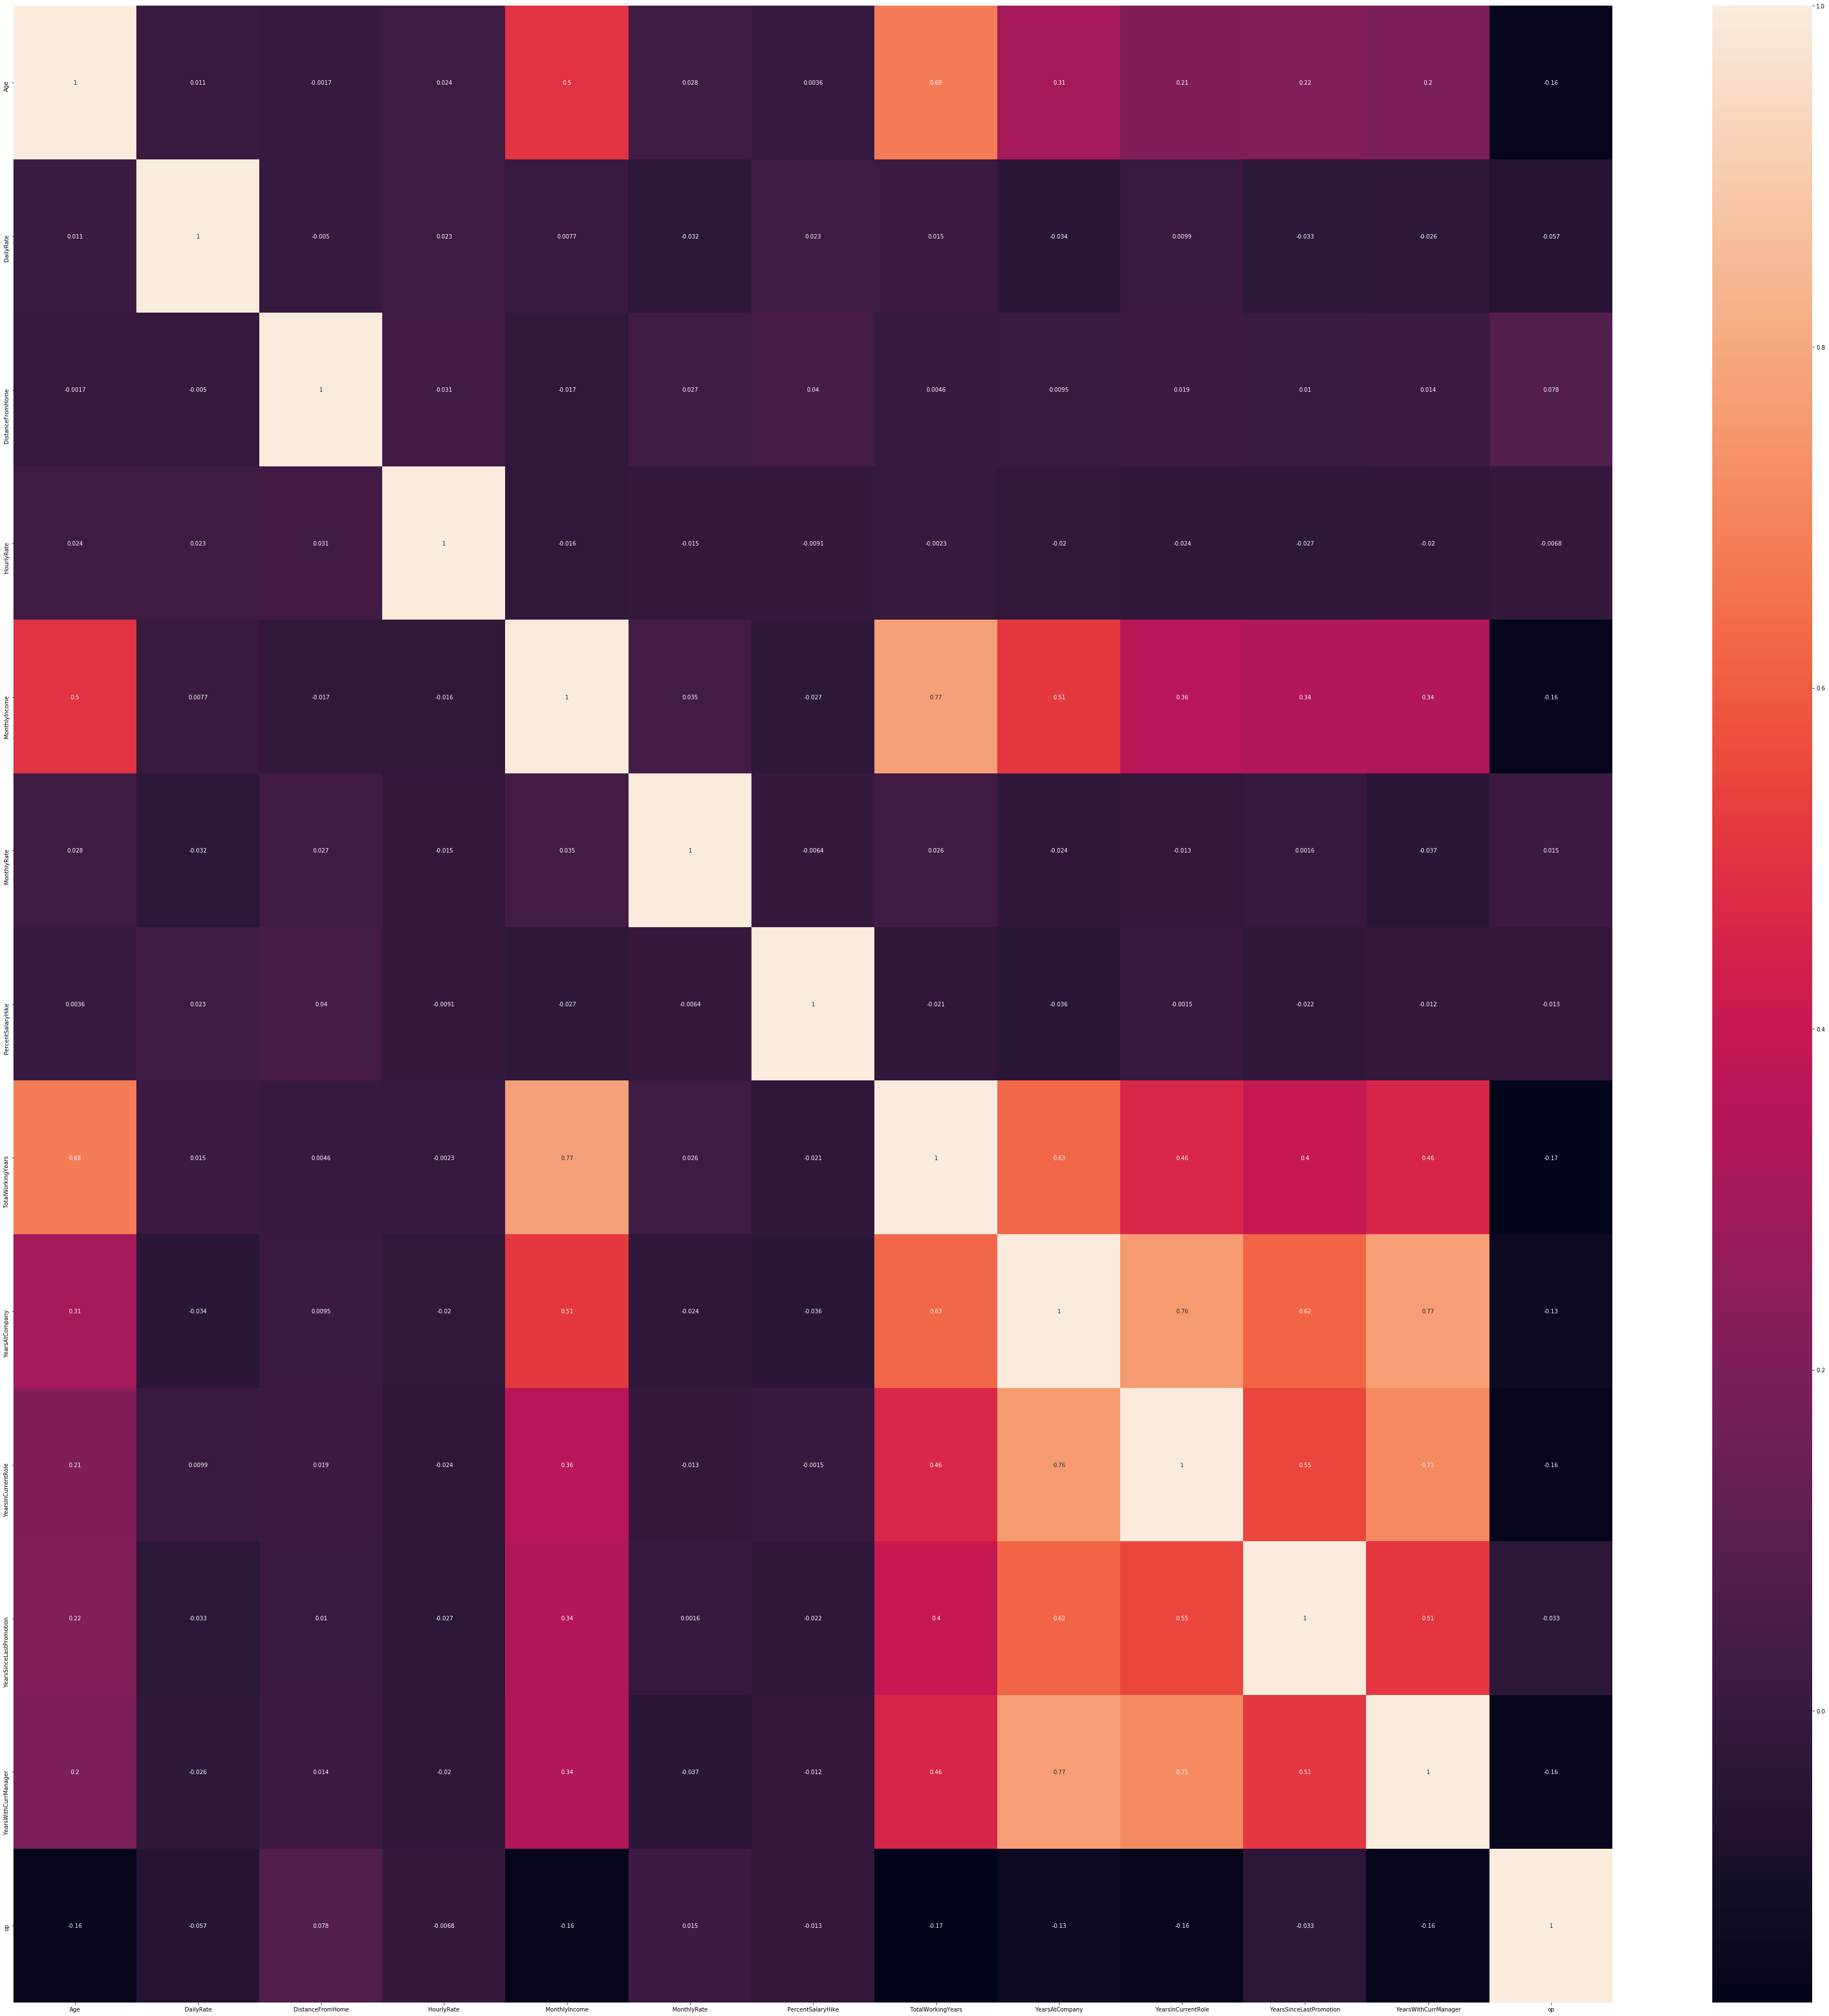

In [13]:
fig,axis=plt.subplots(figsize=(50,50))
sns.heatmap(df_p[l_con+["op"]].corr(),annot=True,ax=axis)
plt.tight_layout()

Most important features

In [14]:
l=[]
l+=list(df_p[l_con+["op"]].corr()["op"][df_p[l_con+["op"]].corr()["op"]>0].index)
l

['DistanceFromHome', 'MonthlyRate', 'op']

Boxplot

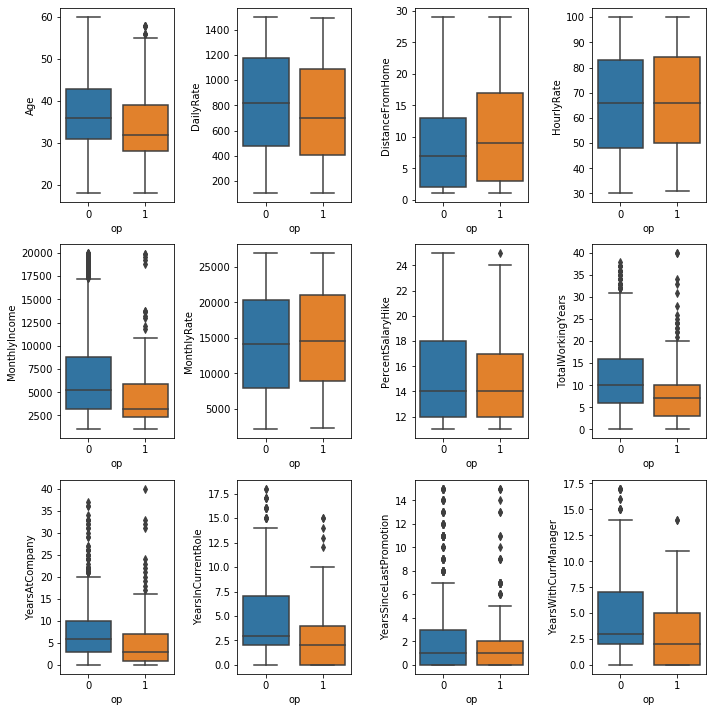

In [15]:
fig,axes=plt.subplots(nrows=3,ncols=4,figsize=(10,10))
axes1=axes.flatten()
index=0
for col in l_con:
    sns.boxplot(x="op",y=col,data=df_p,ax=axes1[index])
    index+=1
plt.tight_layout()

## Step 7:-Visualizing categorical data
countplot

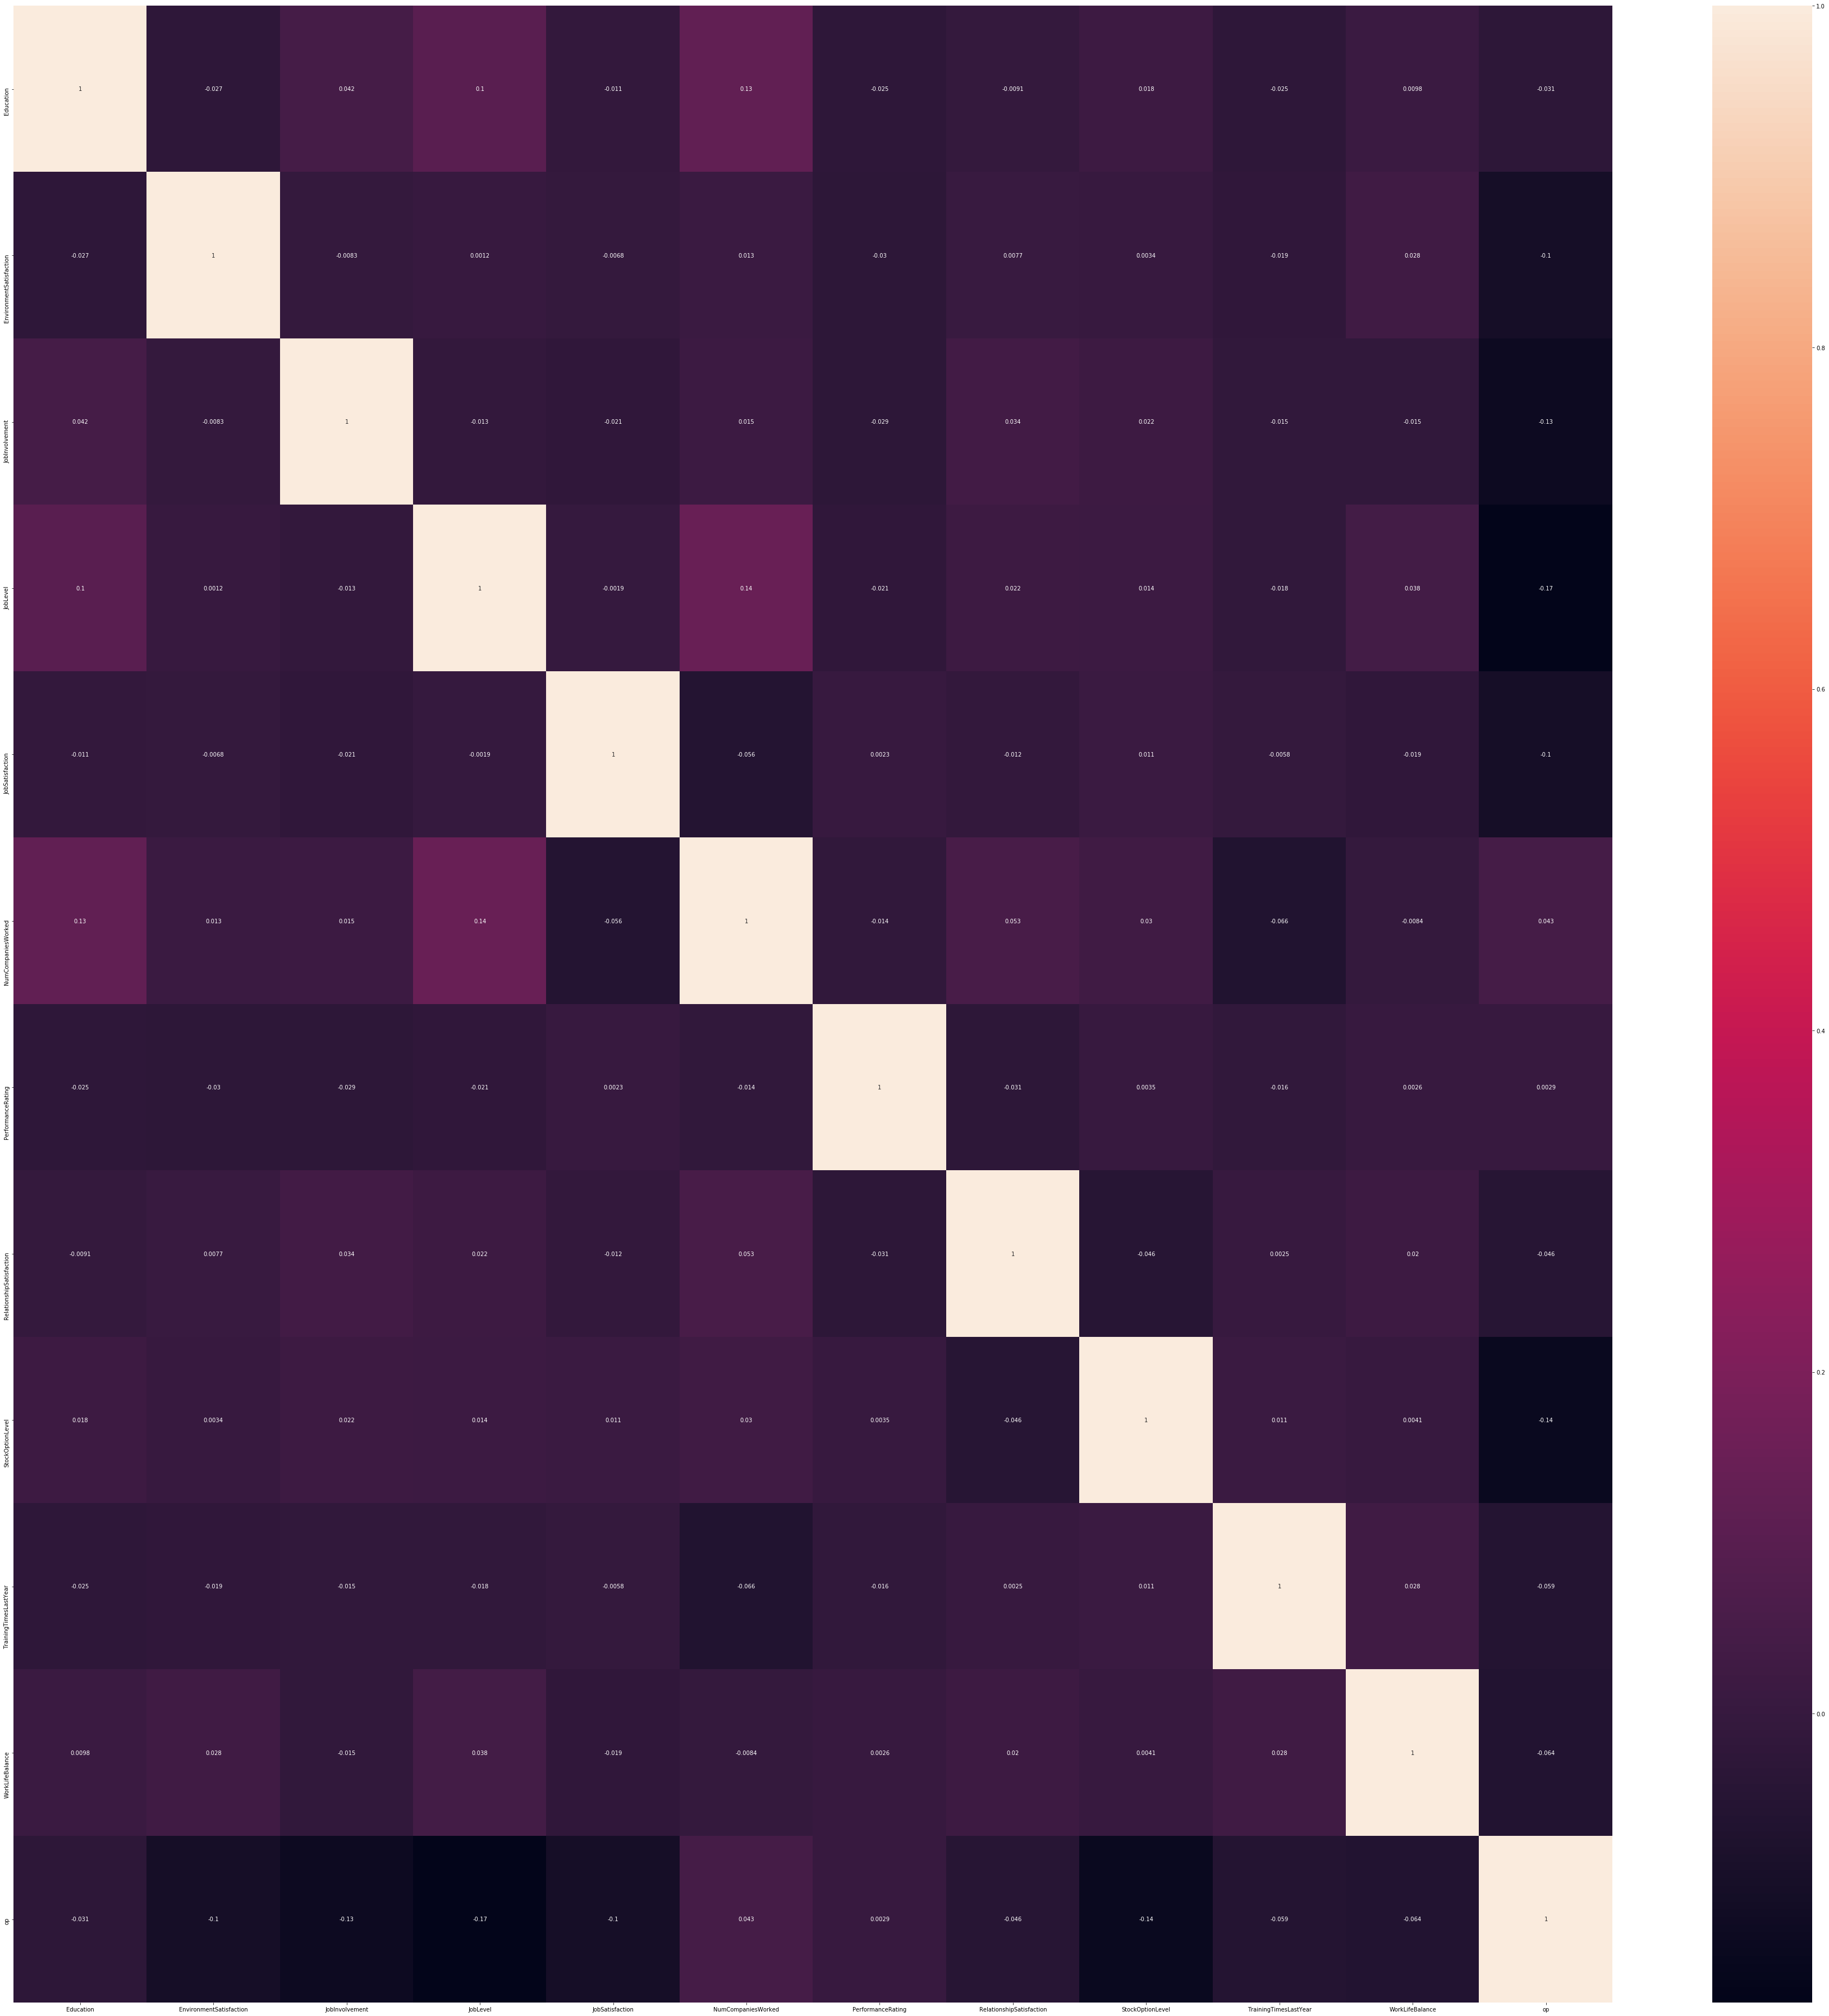

In [16]:
fig,axis=plt.subplots(figsize=(50,50))
sns.heatmap(df_p[l_cat+["op"]].corr(),annot=True,ax=axis)
plt.tight_layout()

In [17]:
l+=list(df_p[l_cat+["op"]].corr()["op"][df_p[l_cat+["op"]].corr()["op"]>0].index)
l

['DistanceFromHome',
 'MonthlyRate',
 'op',
 'NumCompaniesWorked',
 'PerformanceRating',
 'op']

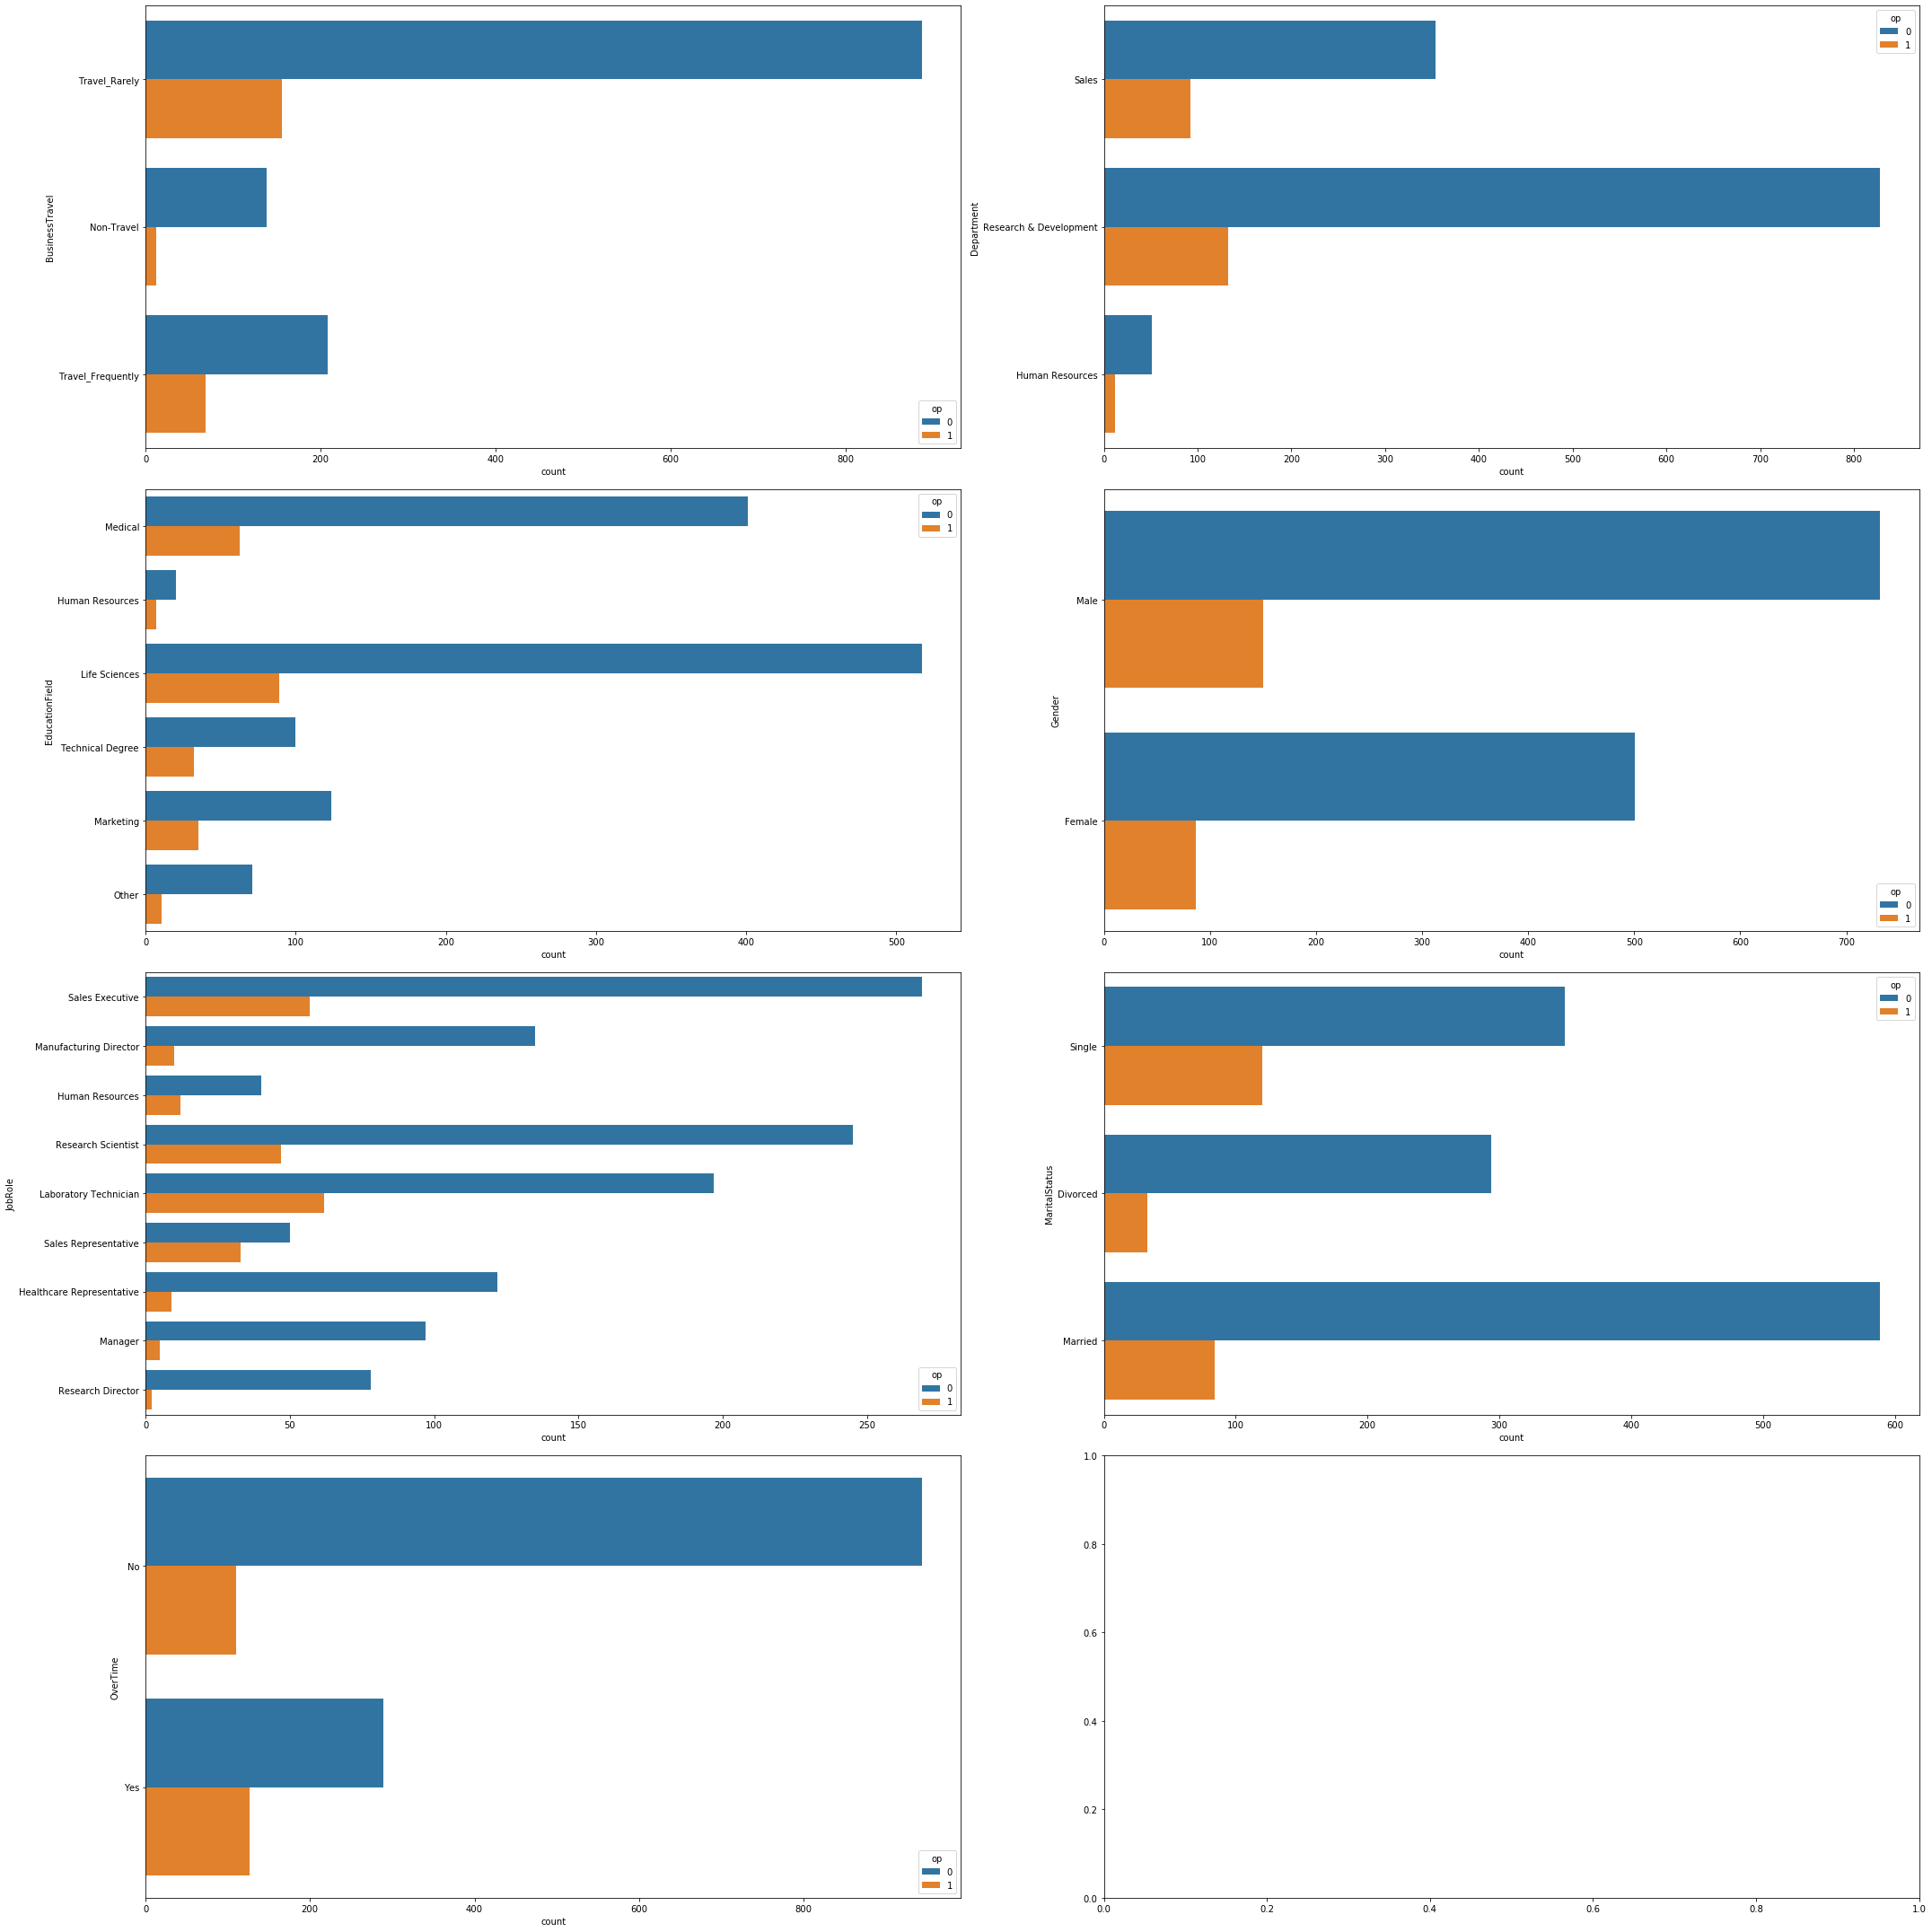

In [18]:
fig,axes=plt.subplots(nrows=4,ncols=2,figsize=(30,30))
axes1=axes.flatten()
index=0
for col in l_str:
    sns.countplot(y=col,hue="op",data=df_p,ax=axes1[index])
    index+=1
plt.tight_layout()

## Step 8:-Encoding catagorical columns

In [19]:

df_p=pd.get_dummies(df_p,columns=l_str)


In [20]:
df_p.columns.values

array(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'op', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Human Resources', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male',
       'JobRole_Healthcare Representative', 'JobRole_Human

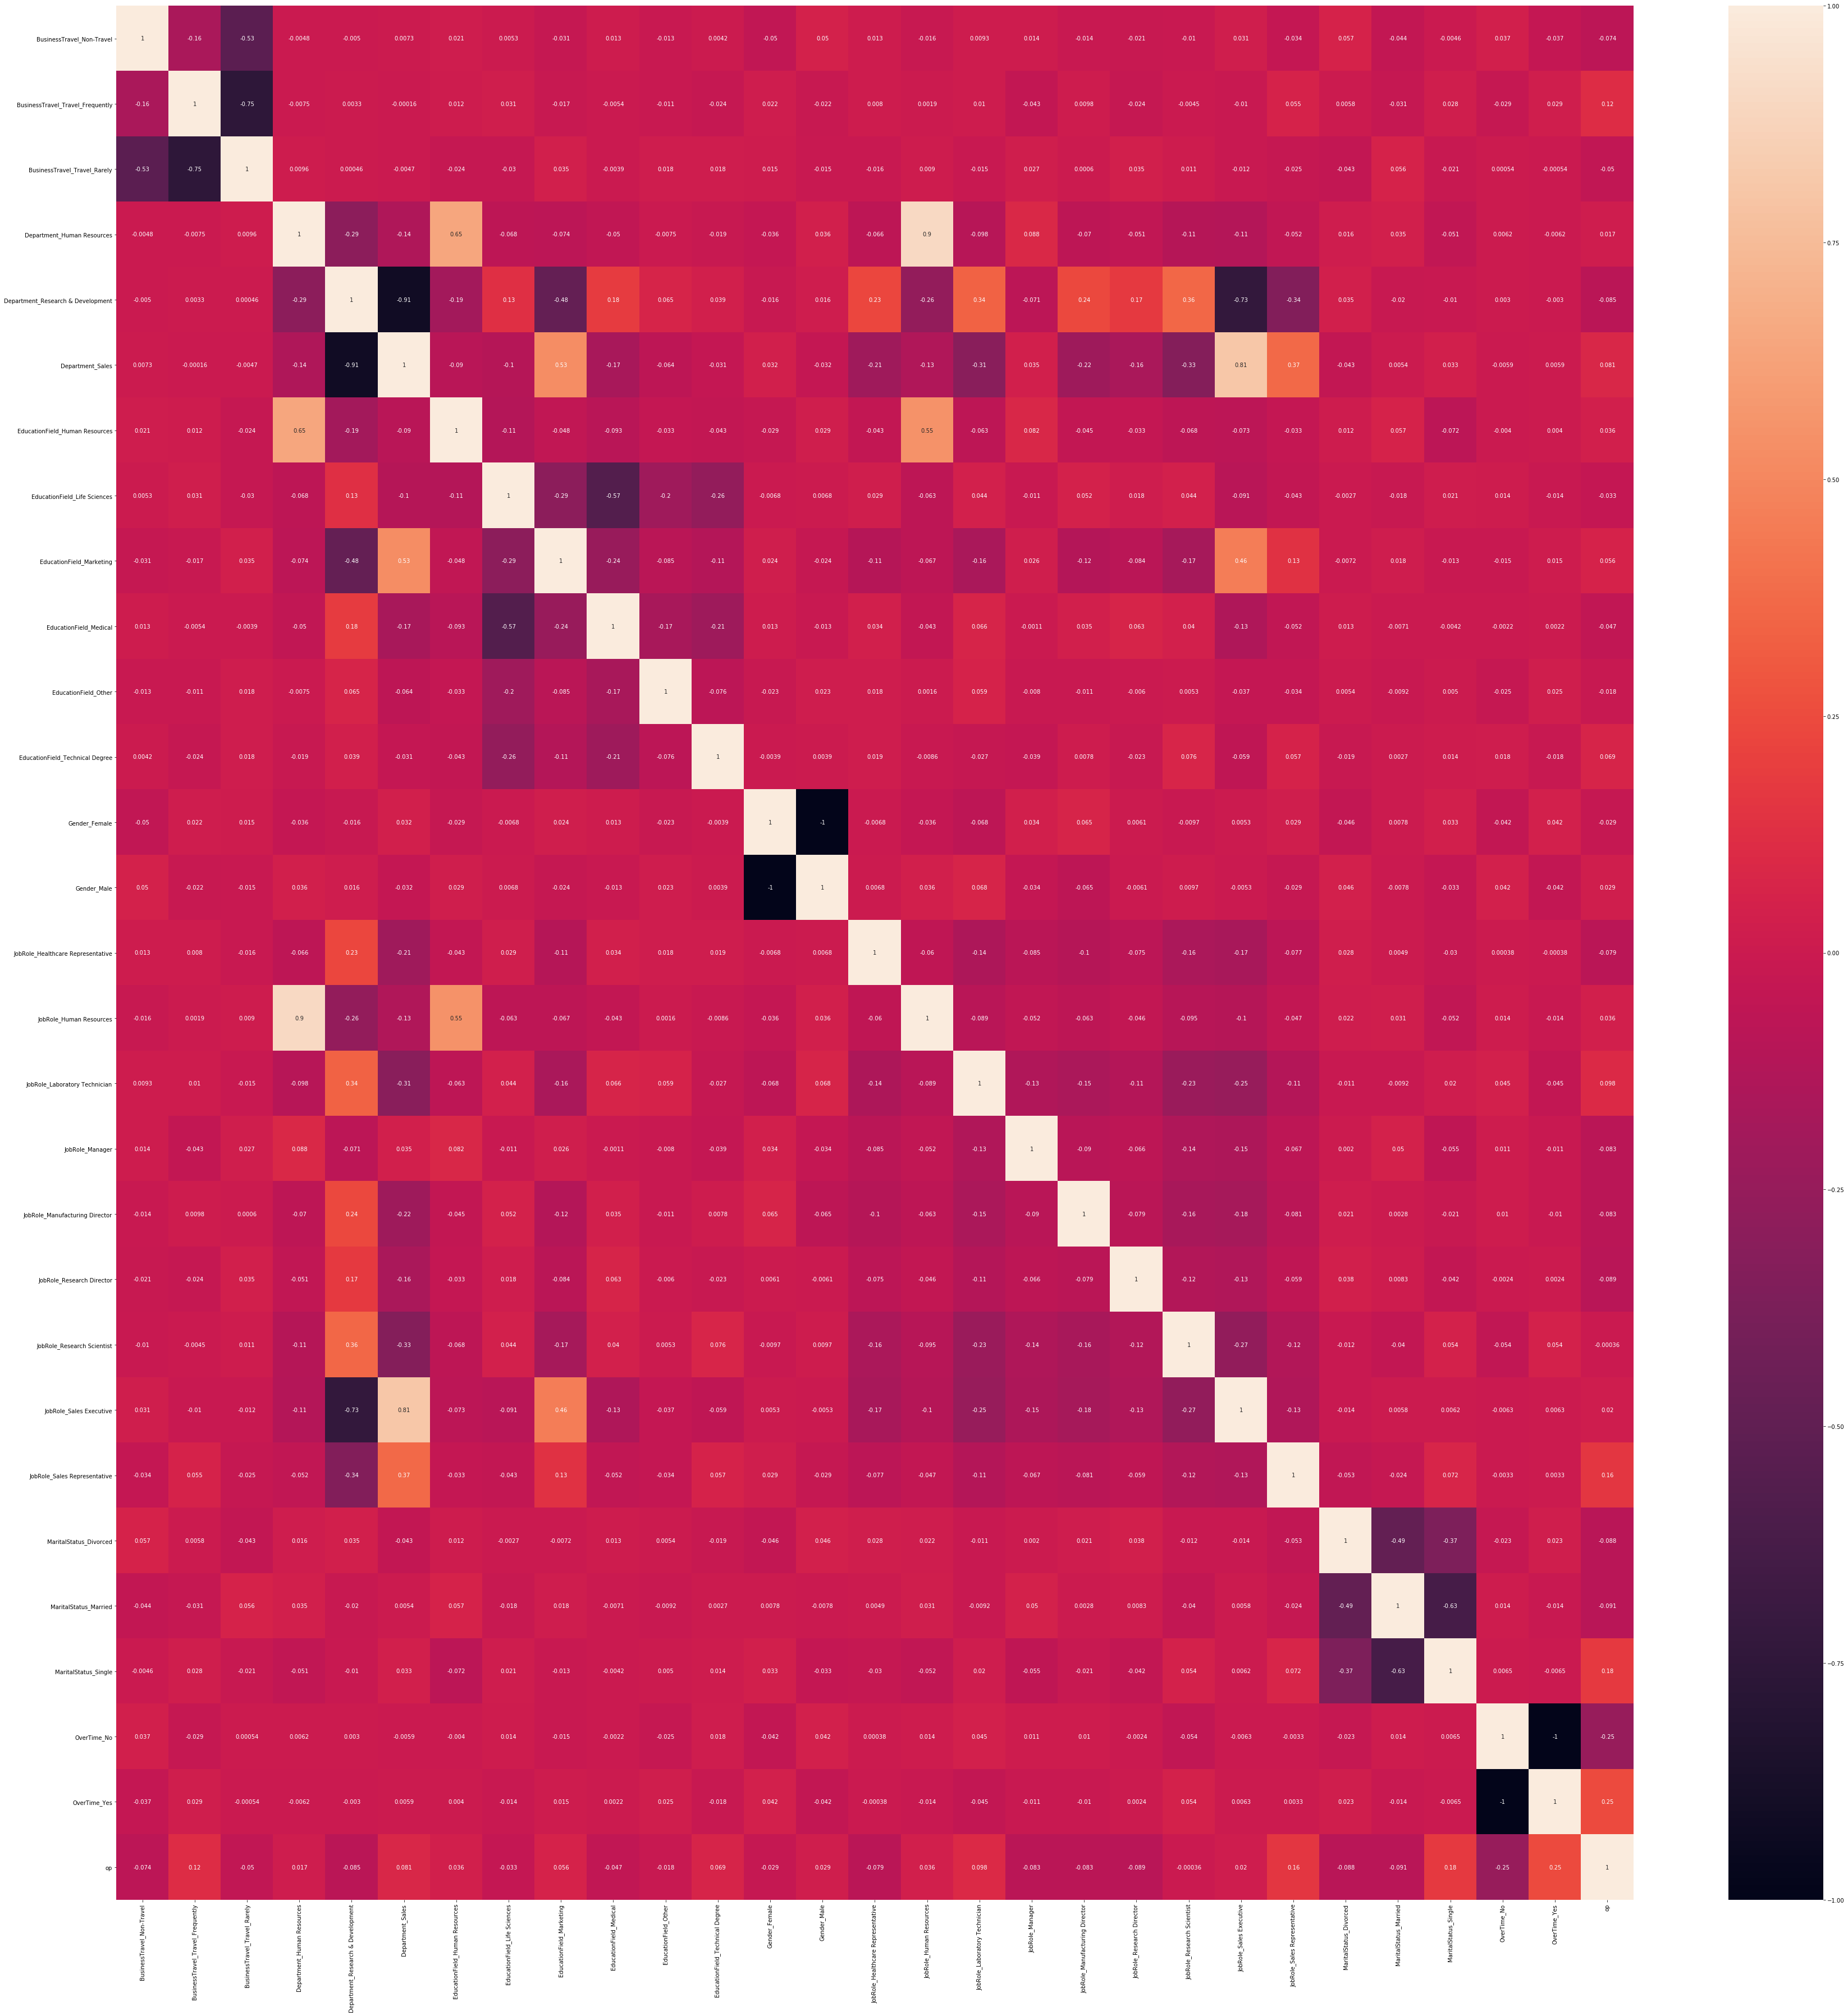

In [21]:
lc=['BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Human Resources', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single', 'OverTime_No',
       'OverTime_Yes']
fig,axis=plt.subplots(figsize=(50,50))
sns.heatmap(df_p[lc+["op"]].corr(),annot=True,ax=axis)
plt.tight_layout()

In [22]:
l+=list(df_p[lc+["op"]].corr()["op"][df_p[lc+["op"]].corr()["op"]>0].index)


In [23]:
y=df_p.op
X=df_p.drop("op",axis=1)
sc = preprocessing.StandardScaler()
x=sc.fit_transform(X)

In [24]:
xtrain,xtest,ytrain,ytest=model_selection.train_test_split(x,y,test_size=0.2,random_state=42)

In [25]:
sm=SMOTE(random_state=42,k_neighbors=2)
xtrainsm,ytrainsm=sm.fit_sample(xtrain,ytrain)

In [26]:

lr = linear_model.LogisticRegression()
lr.fit(sc.transform(xtrainsm),ytrainsm)
testprediction=lr.predict(sc.transform(xtest))
print("Accuracy",metrics.accuracy_score(ytest,testprediction))
print("AUC",metrics.roc_auc_score(ytest,testprediction))
print("recall",metrics.recall_score(ytest,testprediction))
print(metrics.confusion_matrix(ytest,testprediction))
print(metrics.classification_report(ytest,testprediction))

Accuracy 0.7789115646258503
AUC 0.7395901639344263
recall 0.68
[[195  49]
 [ 16  34]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       244
           1       0.41      0.68      0.51        50

    accuracy                           0.78       294
   macro avg       0.67      0.74      0.68       294
weighted avg       0.84      0.78      0.80       294



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
rf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                            max_depth=8, max_features='auto', max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=2, min_samples_split=5,
                            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                            oob_score=False, random_state=0, verbose=0, warm_start=False)
rf.fit(xtrainsm,ytrainsm)
testprediction=rf.predict(xtest)
trainprediction=rf.predict(xtrainsm)
print("Accuracy",metrics.accuracy_score(ytest,testprediction))
print("AUC",metrics.roc_auc_score(ytest,testprediction))
print("recall",metrics.recall_score(ytest,testprediction))
print("Accuracy train",metrics.accuracy_score(ytrainsm,trainprediction))
print("recall train",metrics.recall_score(ytrainsm,trainprediction))


Accuracy 0.8945578231292517
AUC 0.7138524590163935
recall 0.44
Accuracy train 0.9838220424671386
recall train 0.974721941354904


naive byase

In [28]:
nb=naive_bayes.GaussianNB()
nb.fit(xtrainsm,ytrainsm)
testprediction=nb.predict(xtest)
print("Accuracy",metrics.accuracy_score(ytest,testprediction))
print("AUC",metrics.roc_auc_score(ytest,testprediction))
print("recall",metrics.recall_score(ytest,testprediction))

Accuracy 0.6156462585034014
AUC 0.6491803278688525
recall 0.7
